In [1]:
import sys
sys.path.append('../')
from utils import *
from model import *

In [2]:
data_dir = '/datadrive/data_cs/'
batch_size = 256
batch_num  = 128
epoch_num  = 200
samp_num   = 7

device = torch.device("cuda:0")
graph = dill.load(open(data_dir + 'graph.pk', 'rb'))

In [3]:
train_range = {t: True for t in graph.times if t != None and t < 2015}
valid_range = {t: True for t in graph.times if t != None and t >= 2015  and t <= 2016}
test_range  = {t: True for t in graph.times if t != None and t > 2016}

In [9]:
def pf_sample(seed, papers, pairs, t_range, batch_size, test = False):
    np.random.seed(seed)
    _time = np.random.choice(list(papers.keys()))
    sampn = min(len(papers[_time]), batch_size)
    pids = np.array(papers[_time])[np.random.choice(len(papers[_time]), sampn, replace = False)]
    fids = []
    edge = defaultdict(lambda: {})
    for x_id, p_id in enumerate(pids):
        f_ids = pairs[p_id]
        for f_id in f_ids:
            if f_id not in fids:
                fids += [f_id]
            edge[x_id][fids.index(f_id)] = True
    pids = np.stack([pids, np.repeat([_time], sampn)]).T
    fids = np.stack([fids, np.repeat([_time], len(fids))]).T
 
    feature, times, edge_list, _ = sample_subgraph(graph, t_range, \
                inp = {'paper': pids, 'field': fids}, sampled_depth = 3, sampled_number = 100)

    el = []
    for i in edge_list['paper']['field']['rev_PF_in_L2']:
        if i[0] in edge and i[1] in edge[i[0]]:
            continue
        el += [i]
    edge_list['paper']['field']['rev_PF_in_L2'] = el

    el = []
    for i in edge_list['field']['paper']['PF_in_L2']:
        if i[1] in edge and i[0] in edge[i[1]]:
            continue
        el += [i]
    edge_list['field']['paper']['PF_in_L2'] = el
    
    
    node_feature, node_type, edge_time, edge_index, edge_type, node_dict, edge_dict = \
            to_torch(feature, times, edge_list, graph)
    '''
        Trace the paper_id and field_id by its own index plus the type start index
    '''
    paper_ids = np.arange(len(pids)) + node_dict['paper'][0]
    field_ids = np.arange(len(fids)) + node_dict['field'][0]
    ylabel = torch.zeros(sampn, len(cand_list))
    for x_id, p_id in enumerate(pids[:,0]):
        for f_id in pairs[p_id]:
            ylabel[x_id][cand_list.index(f_id)] = 1
    ylabel /= ylabel.sum(axis=1).view(-1, 1)
    return node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel
    
def prepare_data(pool, process_ids):
    jobs = []
    for process_id in process_ids[:-1]:
        p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), train_papers, \
                                               train_pairs, train_range, batch_size))
        jobs.append(p)
    p = pool.apply_async(pf_sample, args=(np.random.randint(2**32 - 1), valid_papers, \
                                           valid_pairs, valid_range, batch_size))
    jobs.append(p)
    return jobs

In [5]:
from torch_geometric.nn import GATConv
class GNN(nn.Module):
    def __init__(self, in_dim, n_hid, num_types, n_layers, dropout = 0.3):
        super(GNN, self).__init__()
        self.gcs = nn.ModuleList()
        self.num_types = num_types
        self.in_dim    = in_dim
        self.n_hid     = n_hid
        self.aggregat_ws   = nn.ModuleList()
        self.drop          = nn.Dropout(dropout)
        for t in range(num_types):
            self.aggregat_ws.append(nn.Linear(in_dim, n_hid))
        for l in range(n_layers):
            self.gcs.append(GATConv(n_hid, n_hid // 8, heads=8))
    def forward(self, node_feature, node_type, edge_index):
        res = torch.zeros(node_feature.size(0), self.n_hid).to(node_feature.device)
        for t_id in range(self.num_types):
            aggregat_w = self.aggregat_ws[t_id]
            idx = (node_type == t_id)
            if idx.sum() == 0:
                continue
            res[idx] = torch.tanh(aggregat_w(node_feature[idx]))
        meta_xs = self.drop(res)
        del res
        for gc in self.gcs:
            meta_xs = self.drop(F.relu(gc(meta_xs, edge_index)))
        return meta_xs

In [6]:
'''
Paper-Field
'''
paper_ser = {}

train_pairs = {}
valid_pairs = {}
test_pairs  = {}

train_papers = {_time: {} for _time in train_range}
valid_papers = {_time: {} for _time in valid_range}
test_papers  = {_time: {} for _time in test_range}

for f_id in graph.edge_list['field']['paper']['PF_in_L2']:
    for p_id in graph.edge_list['field']['paper']['PF_in_L2'][f_id]:
        _time = graph.edge_list['field']['paper']['PF_in_L2'][f_id][p_id]
        if _time in train_range:
            if p_id not in train_pairs:
                train_pairs[p_id] = []
            train_pairs[p_id] += [f_id]
            train_papers[_time][p_id] = True
        elif _time in valid_range:
            if p_id not in valid_pairs:
                valid_pairs[p_id] = []
            valid_pairs[p_id] += [f_id]
            valid_papers[_time][p_id] = True
        else:
            if p_id not in test_pairs:
                test_pairs[p_id] = []
            test_pairs[p_id] += [f_id]
            test_papers[_time][p_id] = True
for _time in list(train_papers.keys()):
    if len(train_papers[_time]) < batch_size // 2:
        train_papers.pop(_time)
    else:
        train_papers[_time] = np.array(list(train_papers[_time].keys()))
for _time in list(valid_papers.keys()):
    if len(valid_papers[_time]) < batch_size // 2:
        valid_papers.pop(_time)
    else:
        valid_papers[_time] = np.array(list(valid_papers[_time].keys()))
for _time in list(test_papers.keys()):
    if len(test_papers[_time]) < batch_size // 2:
        test_papers.pop(_time)
    else:
        test_papers[_time] = np.array(list(test_papers[_time].keys()))

In [7]:
types = graph.get_types()
cand_list = list(graph.edge_list['field']['paper']['PF_in_L2'])
gnn = GNN(in_dim = len(graph.node_feature['paper']['emb'][0]) + 401, n_hid = 256, n_layers = 3, num_types = len(types)).to(device)
classifier = Classifier(256, len(cand_list)).to(device)
model = nn.Sequential(gnn, classifier)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000, eta_min=1e-6)

In [10]:
stats = []
pool = mp.Pool(4)
process_ids = np.arange(batch_num // 4)
st = time.time()
jobs = prepare_data(pool, process_ids)
train_step = 1500
best_val   = 0
res = []
criterion = nn.KLDivLoss(reduction='batchmean')
for epoch in np.arange(epoch_num)+1:
    '''
        Prepare Training and Validation Data
    '''
    train_data = [job.get() for job in jobs[:-1]]
    valid_data = jobs[-1].get()
    pool.close()
    pool.join()
    pool = mp.Pool(4)
    jobs = prepare_data(pool, process_ids)
    et = time.time()
    print('Data Preparation: %.1fs' % (et - st))
    
    
    model.train()
    train_losses = []
    for batch in np.arange(5):
        for node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel in train_data:
            node_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))
            res  = classifier.forward(node_rep[paper_ids])
            loss = criterion(res, ylabel.to(device))
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            train_losses += [loss.cpu().detach().tolist()]
            train_step += 1
            scheduler.step(train_step)
    '''
        Valid
    '''
    model.eval()
    with torch.no_grad():
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = valid_data
        node_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))
        res  = classifier.forward(node_rep[paper_ids])
        loss = criterion(res, ylabel.to(device))
        valid_res = []

        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            valid_res += [ai[bi].tolist()]
        valid_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in valid_res])
        if valid_ndcg > best_val:
            best_val = valid_ndcg
            torch.save(model, './save/gat.pt')
        st = time.time()
        print(("Epoch: %d (%.1fs)  LR: %.5f Train Loss: %.2f  Valid Loss: %.2f  Valid NDCG: %.4f") % \
              (epoch, (st-et), optimizer.param_groups[0]['lr'], np.average(train_losses), loss.cpu().detach().tolist(),\
              valid_ndcg))
        stats += [[np.average(train_losses), loss.cpu().detach().tolist()]]
        if epoch % 5 == 0:
            '''
                Test
            '''
            _time = np.random.choice(list(test_papers.keys()))
            node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                           test_pairs, test_range, batch_size, test=True)
            paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))[paper_ids]
            res = classifier.forward(paper_rep)
            test_res = []
            for ai, bi in zip(ylabel, res.argsort(descending = True)):
                test_res += [ai[bi].tolist()]
            test_ndcg = np.average([ndcg_at_k(resi, len(resi)) for resi in test_res])
            print("Test NDCG: " + str(test_ndcg))
    del train_data, valid_data

Data Preparation: 304.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1 (62.2s)  LR: 0.00073 Train Loss: 6.22  Valid Loss: 6.39  Valid NDCG: 0.2066
Data Preparation: 262.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2 (71.3s)  LR: 0.00091 Train Loss: 6.12  Valid Loss: 6.53  Valid NDCG: 0.2138
Data Preparation: 261.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 3 (60.4s)  LR: 0.00100 Train Loss: 6.07  Valid Loss: 6.12  Valid NDCG: 0.2273
Data Preparation: 259.7s
Epoch: 4 (59.8s)  LR: 0.00096 Train Loss: 5.91  Valid Loss: 6.27  Valid NDCG: 0.2193
Data Preparation: 252.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 5 (68.5s)  LR: 0.00082 Train Loss: 5.82  Valid Loss: 6.23  Valid NDCG: 0.2362
Test NDCG: 0.22828370243728097
Data Preparation: 262.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 6 (68.8s)  LR: 0.00061 Train Loss: 5.70  Valid Loss: 6.08  Valid NDCG: 0.2395
Data Preparation: 265.2s
Epoch: 7 (66.9s)  LR: 0.00037 Train Loss: 5.66  Valid Loss: 6.25  Valid NDCG: 0.2367
Data Preparation: 260.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 8 (67.4s)  LR: 0.00016 Train Loss: 5.67  Valid Loss: 5.92  Valid NDCG: 0.2400
Data Preparation: 271.9s
Epoch: 9 (70.4s)  LR: 0.00003 Train Loss: 5.59  Valid Loss: 6.06  Valid NDCG: 0.2395
Data Preparation: 267.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 10 (69.9s)  LR: 0.00001 Train Loss: 5.62  Valid Loss: 5.89  Valid NDCG: 0.2558
Test NDCG: 0.23731540526042394
Data Preparation: 270.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 11 (69.3s)  LR: 0.00010 Train Loss: 5.73  Valid Loss: 5.89  Valid NDCG: 0.2616
Data Preparation: 263.2s
Epoch: 12 (69.9s)  LR: 0.00029 Train Loss: 5.59  Valid Loss: 6.23  Valid NDCG: 0.2397
Data Preparation: 269.2s
Epoch: 13 (68.8s)  LR: 0.00052 Train Loss: 5.54  Valid Loss: 6.03  Valid NDCG: 0.2603
Data Preparation: 270.8s
Epoch: 14 (71.6s)  LR: 0.00075 Train Loss: 5.47  Valid Loss: 6.29  Valid NDCG: 0.2418
Data Preparation: 275.7s
Epoch: 15 (73.3s)  LR: 0.00093 Train Loss: 5.42  Valid Loss: 6.08  Valid NDCG: 0.2564
Test NDCG: 0.2497621349868073
Data Preparation: 269.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 16 (72.0s)  LR: 0.00100 Train Loss: 5.33  Valid Loss: 5.93  Valid NDCG: 0.2724
Data Preparation: 275.9s
Epoch: 17 (71.1s)  LR: 0.00096 Train Loss: 5.38  Valid Loss: 5.65  Valid NDCG: 0.2670
Data Preparation: 280.0s
Epoch: 18 (74.3s)  LR: 0.00081 Train Loss: 5.17  Valid Loss: 5.85  Valid NDCG: 0.2555
Data Preparation: 274.1s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 19 (70.3s)  LR: 0.00059 Train Loss: 5.15  Valid Loss: 5.72  Valid NDCG: 0.2759
Data Preparation: 289.2s
Epoch: 20 (71.1s)  LR: 0.00035 Train Loss: 5.17  Valid Loss: 5.74  Valid NDCG: 0.2644
Test NDCG: 0.2549665340645544
Data Preparation: 283.3s
Epoch: 21 (69.0s)  LR: 0.00014 Train Loss: 5.18  Valid Loss: 5.58  Valid NDCG: 0.2758
Data Preparation: 274.6s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 22 (70.3s)  LR: 0.00002 Train Loss: 5.19  Valid Loss: 5.61  Valid NDCG: 0.2762
Data Preparation: 284.8s
Epoch: 23 (72.3s)  LR: 0.00001 Train Loss: 5.16  Valid Loss: 5.84  Valid NDCG: 0.2641
Data Preparation: 274.5s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 24 (72.2s)  LR: 0.00012 Train Loss: 5.28  Valid Loss: 5.79  Valid NDCG: 0.2792
Data Preparation: 284.8s
Epoch: 25 (71.7s)  LR: 0.00031 Train Loss: 5.13  Valid Loss: 5.75  Valid NDCG: 0.2722
Test NDCG: 0.23243814111344543
Data Preparation: 290.5s
Epoch: 26 (73.8s)  LR: 0.00055 Train Loss: 5.04  Valid Loss: 5.72  Valid NDCG: 0.2672
Data Preparation: 287.6s
Epoch: 27 (72.7s)  LR: 0.00077 Train Loss: 5.12  Valid Loss: 5.77  Valid NDCG: 0.2725
Data Preparation: 285.4s
Epoch: 28 (69.9s)  LR: 0.00094 Train Loss: 5.05  Valid Loss: 5.77  Valid NDCG: 0.2692
Data Preparation: 272.3s
Epoch: 29 (70.2s)  LR: 0.00100 Train Loss: 4.87  Valid Loss: 5.70  Valid NDCG: 0.2769
Data Preparation: 280.2s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 30 (72.8s)  LR: 0.00095 Train Loss: 5.00  Valid Loss: 5.58  Valid NDCG: 0.2892
Test NDCG: 0.2518439633857126
Data Preparation: 278.4s
Epoch: 31 (72.3s)  LR: 0.00079 Train Loss: 4.82  Valid Loss: 5.77  Valid NDCG: 0.2640
Data Preparation: 273.6s
Epoch: 32 (70.3s)  LR: 0.00056 Train Loss: 5.01  Valid Loss: 5.61  Valid NDCG: 0.2840
Data Preparation: 272.7s
Epoch: 33 (74.1s)  LR: 0.00032 Train Loss: 4.74  Valid Loss: 5.74  Valid NDCG: 0.2650
Data Preparation: 278.2s
Epoch: 34 (74.9s)  LR: 0.00013 Train Loss: 4.84  Valid Loss: 5.56  Valid NDCG: 0.2759
Data Preparation: 278.4s
Epoch: 35 (68.5s)  LR: 0.00001 Train Loss: 5.05  Valid Loss: 5.58  Valid NDCG: 0.2736
Test NDCG: 0.2916938528500356
Data Preparation: 284.8s
Epoch: 36 (72.9s)  LR: 0.00002 Train Loss: 4.98  Valid Loss: 5.65  Valid NDCG: 0.2723
Data Preparation: 280.2s
Epoch: 37 (71.7s)  LR: 0.00013 Train Loss: 5.02  Valid Loss: 5.64  Valid NDCG: 0.2848
Data Preparation: 281.2s
Epoch: 38 (74.2s)  LR: 0.00033 Train Loss: 4.99  Val

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 46 (73.4s)  LR: 0.00030 Train Loss: 4.57  Valid Loss: 5.68  Valid NDCG: 0.2912
Data Preparation: 277.7s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 47 (69.8s)  LR: 0.00011 Train Loss: 4.76  Valid Loss: 5.52  Valid NDCG: 0.2946
Data Preparation: 289.2s
Epoch: 48 (72.0s)  LR: 0.00001 Train Loss: 4.72  Valid Loss: 5.65  Valid NDCG: 0.2614
Data Preparation: 278.3s


/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 49 (72.7s)  LR: 0.00002 Train Loss: 4.72  Valid Loss: 5.36  Valid NDCG: 0.3079
Data Preparation: 275.9s
Epoch: 50 (68.8s)  LR: 0.00015 Train Loss: 4.73  Valid Loss: 5.73  Valid NDCG: 0.2779
Test NDCG: 0.3100323482720163
Data Preparation: 274.4s
Epoch: 51 (75.1s)  LR: 0.00035 Train Loss: 4.69  Valid Loss: 5.40  Valid NDCG: 0.2998
Data Preparation: 279.4s
Epoch: 52 (69.6s)  LR: 0.00059 Train Loss: 4.66  Valid Loss: 5.77  Valid NDCG: 0.2734
Data Preparation: 280.0s
Epoch: 53 (72.4s)  LR: 0.00081 Train Loss: 4.74  Valid Loss: 5.44  Valid NDCG: 0.2846
Data Preparation: 274.5s
Epoch: 54 (68.1s)  LR: 0.00096 Train Loss: 4.49  Valid Loss: 5.96  Valid NDCG: 0.2532
Data Preparation: 263.6s
Epoch: 55 (67.0s)  LR: 0.00100 Train Loss: 4.65  Valid Loss: 5.45  Valid NDCG: 0.3048
Test NDCG: 0.2713985896465387
Data Preparation: 263.0s
Epoch: 56 (69.0s)  LR: 0.00092 Train Loss: 4.62  Valid Loss: 5.40  Valid NDCG: 0.2926
Data Preparation: 264.2s
Epoch: 57 (71.6s)  LR: 0.00075 Train Loss: 4.62  Val

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 59 (69.9s)  LR: 0.00028 Train Loss: 4.78  Valid Loss: 5.25  Valid NDCG: 0.3201
Data Preparation: 278.9s
Epoch: 60 (72.6s)  LR: 0.00010 Train Loss: 4.44  Valid Loss: 5.51  Valid NDCG: 0.2821
Test NDCG: 0.2922110297437839
Data Preparation: 273.6s
Epoch: 61 (69.8s)  LR: 0.00001 Train Loss: 4.69  Valid Loss: 5.57  Valid NDCG: 0.2861
Data Preparation: 275.0s
Epoch: 62 (69.8s)  LR: 0.00003 Train Loss: 4.77  Valid Loss: 5.73  Valid NDCG: 0.2731
Data Preparation: 284.6s
Epoch: 63 (70.1s)  LR: 0.00016 Train Loss: 4.79  Valid Loss: 5.63  Valid NDCG: 0.2782
Data Preparation: 277.5s
Epoch: 64 (69.3s)  LR: 0.00038 Train Loss: 4.49  Valid Loss: 5.50  Valid NDCG: 0.2862
Data Preparation: 276.1s
Epoch: 65 (72.0s)  LR: 0.00062 Train Loss: 4.72  Valid Loss: 6.05  Valid NDCG: 0.2588
Test NDCG: 0.26699706373674964
Data Preparation: 280.6s
Epoch: 66 (72.9s)  LR: 0.00083 Train Loss: 4.50  Valid Loss: 6.05  Valid NDCG: 0.2557
Data Preparation: 276.6s
Epoch: 67 (69.9s)  LR: 0.00097 Train Loss: 4.62  Va

Data Preparation: 278.7s
Epoch: 129 (67.8s)  LR: 0.00049 Train Loss: 4.24  Valid Loss: 5.93  Valid NDCG: 0.2936
Data Preparation: 275.8s
Epoch: 130 (70.9s)  LR: 0.00073 Train Loss: 4.07  Valid Loss: 6.49  Valid NDCG: 0.2658
Test NDCG: 0.2753943776982684
Data Preparation: 282.5s
Epoch: 131 (72.2s)  LR: 0.00091 Train Loss: 4.41  Valid Loss: 5.51  Valid NDCG: 0.3133
Data Preparation: 304.9s
Epoch: 132 (71.8s)  LR: 0.00100 Train Loss: 4.47  Valid Loss: 5.75  Valid NDCG: 0.2844
Data Preparation: 290.6s
Epoch: 133 (72.1s)  LR: 0.00097 Train Loss: 4.03  Valid Loss: 5.80  Valid NDCG: 0.2940
Data Preparation: 277.6s
Epoch: 134 (72.2s)  LR: 0.00083 Train Loss: 4.28  Valid Loss: 5.74  Valid NDCG: 0.2918
Data Preparation: 285.9s
Epoch: 135 (70.5s)  LR: 0.00062 Train Loss: 4.29  Valid Loss: 6.07  Valid NDCG: 0.3004
Test NDCG: 0.29610983281988135
Data Preparation: 290.1s
Epoch: 136 (73.7s)  LR: 0.00038 Train Loss: 3.95  Valid Loss: 6.21  Valid NDCG: 0.2954
Data Preparation: 294.9s
Epoch: 137 (72.5s)

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 178 (59.1s)  LR: 0.00002 Train Loss: 4.37  Valid Loss: 5.73  Valid NDCG: 0.3242
Data Preparation: 267.2s
Epoch: 179 (63.8s)  LR: 0.00014 Train Loss: 4.20  Valid Loss: 6.10  Valid NDCG: 0.3109
Data Preparation: 270.9s
Epoch: 180 (60.8s)  LR: 0.00035 Train Loss: 4.22  Valid Loss: 5.87  Valid NDCG: 0.3002
Test NDCG: 0.2891014165003342
Data Preparation: 268.9s
Epoch: 181 (62.7s)  LR: 0.00059 Train Loss: 3.85  Valid Loss: 5.93  Valid NDCG: 0.3061
Data Preparation: 267.5s
Epoch: 182 (61.8s)  LR: 0.00081 Train Loss: 4.12  Valid Loss: 5.78  Valid NDCG: 0.3207
Data Preparation: 274.5s
Epoch: 183 (60.4s)  LR: 0.00096 Train Loss: 4.32  Valid Loss: 5.84  Valid NDCG: 0.3078
Data Preparation: 274.1s
Epoch: 184 (61.7s)  LR: 0.00100 Train Loss: 4.26  Valid Loss: 5.94  Valid NDCG: 0.2952
Data Preparation: 271.9s
Epoch: 185 (60.0s)  LR: 0.00093 Train Loss: 4.20  Valid Loss: 5.80  Valid NDCG: 0.3060
Test NDCG: 0.31848549245868735
Data Preparation: 266.0s
Epoch: 186 (58.5s)  LR: 0.00075 Train Loss:

/home/ziniu/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 189 (61.2s)  LR: 0.00010 Train Loss: 4.15  Valid Loss: 5.77  Valid NDCG: 0.3277
Data Preparation: 269.6s
Epoch: 190 (63.0s)  LR: 0.00001 Train Loss: 3.92  Valid Loss: 6.36  Valid NDCG: 0.2778
Test NDCG: 0.30174551636831803
Data Preparation: 272.9s
Epoch: 191 (62.4s)  LR: 0.00003 Train Loss: 4.16  Valid Loss: 5.95  Valid NDCG: 0.2932
Data Preparation: 269.2s
Epoch: 192 (59.6s)  LR: 0.00016 Train Loss: 4.00  Valid Loss: 6.09  Valid NDCG: 0.3008
Data Preparation: 275.7s
Epoch: 193 (61.3s)  LR: 0.00037 Train Loss: 4.10  Valid Loss: 6.37  Valid NDCG: 0.2962
Data Preparation: 258.3s
Epoch: 194 (61.2s)  LR: 0.00061 Train Loss: 3.62  Valid Loss: 6.39  Valid NDCG: 0.2896
Data Preparation: 266.6s
Epoch: 195 (61.2s)  LR: 0.00082 Train Loss: 3.92  Valid Loss: 6.21  Valid NDCG: 0.2876
Test NDCG: 0.32247962116864987
Data Preparation: 272.3s
Epoch: 196 (62.0s)  LR: 0.00096 Train Loss: 3.95  Valid Loss: 6.31  Valid NDCG: 0.2882
Data Preparation: 269.6s
Epoch: 197 (62.4s)  LR: 0.00100 Train Loss

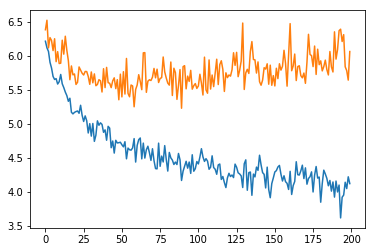

In [11]:
stats = np.array(stats)
plt.plot(stats[:,0])
plt.plot(stats[:,1])
plt.show()

In [12]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.3033617751869837 0.023710559741321295
0.27481465989533627 0.11675060589725392


In [13]:
model = torch.load('./save/gat.pt')

In [15]:
model.eval()
gnn, classifier = model
with torch.no_grad():
    test_res = []
    for _ in range(10):
        _time = np.random.choice(list(test_papers.keys()))
        node_feature, node_type, edge_time, edge_index, edge_type, field_ids, paper_ids, ylabel = pf_sample(np.random.randint(2 ** 32 - 1), test_papers, \
                                                       test_pairs, test_range, batch_size, test=True)
        paper_rep = gnn.forward(node_feature.to(device), node_type.to(device), edge_index.to(device))[paper_ids]
        res = classifier.forward(paper_rep)
        for ai, bi in zip(ylabel, res.argsort(descending = True)):
            test_res += [ai[bi].tolist()]
    test_ndcg = [ndcg_at_k(resi, len(resi)) for resi in test_res]
    print(np.average(test_ndcg), np.var(test_ndcg))
    test_mrr = mean_reciprocal_rank(test_res)
    print(np.average(test_mrr), np.var(test_mrr))

0.3048935531114347 0.023582004529036752
0.2863674528983614 0.12391703636809256
